<a href="https://colab.research.google.com/github/dheerajvarma24/DCGANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: add comments, referecnes.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

In [2]:
ds = tfds.load('fashion_mnist', split='train')

In [3]:
dataiterator = ds.as_numpy_iterator()

In [4]:
dataiterator.next()['image'].shape

(28, 28, 1)

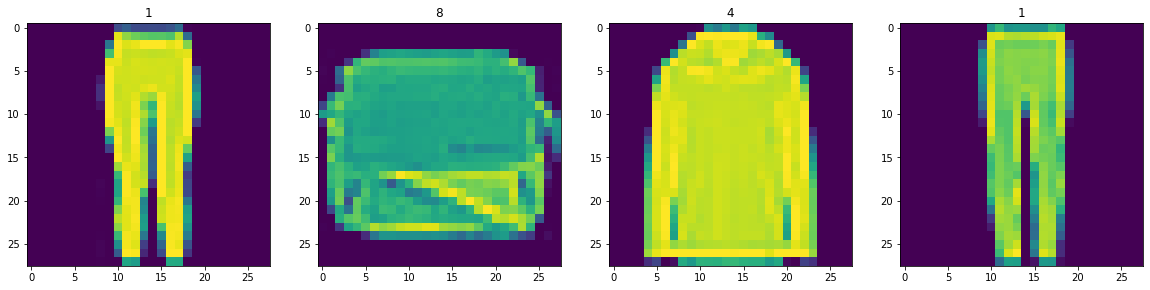

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [6]:
def scale_image(data):
  return data['image']/255

In [7]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_image)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, Flatten, Dense, LeakyReLU, Reshape, Dropout


In [9]:
def generator_model():
  model = Sequential()

  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, (5,5), padding='same'))
  model.add(LeakyReLU(0.2))
  
  model.add(UpSampling2D())
  model.add(Conv2D(128, (5,5), padding='same'))
  model.add(LeakyReLU(0.2))

  
  model.add(Conv2D(128, (4,4), padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, (4,4), padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, (4,4), padding='same', activation='sigmoid'))


  return model


In [10]:
generator = generator_model()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

To calculate number of parametres : reference: https://stackoverflow.com/questions/42786717/how-to-calculate-the-number-of-parameters-for-convolutional-neural-network

if input has 128 feature maps and filter size is 5*5 and we need again 128 featuremaps in output then #parameters = [(128 *5 * 5) * (128) ] + 128(bias terms = number of feature maps in output) = 409728

In [12]:
def descriminator_model():
  model = Sequential()

  model.add(Conv2D(32, (5,5), input_shape=(28,28,1) ))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, (5,5) ))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (5,5) ))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, (5,5) ))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [13]:
descriminator = descriminator_model()

In [14]:
descriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
from tensorflow.keras.optimizers import Adam
from IPython import display

Assumption 0 is for fake values 1 is for real images

In [16]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
def descriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return (real_loss + fake_loss)


In [18]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.0001)

In [19]:
EPOCHS = 100
BATCH_SIZE = 128
noise_dim = 128
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
@tf.function
def gan_train(images):
  random_noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(random_noise, training=True)

    real_output = descriminator(images, training=True)
    fake_output = descriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = descriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, descriminator.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, descriminator.trainable_variables))

  return {"d_loss":disc_loss, "g_loss":gen_loss}



In [21]:
import time
import os

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_opt,
                                 discriminator_optimizer=d_opt,
                                 generator=generator,
                                 discriminator=descriminator)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [24]:
def train(dataset, epochs):
  losses_array= []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      batch_loss = gan_train(image_batch)
    losses_array.append(batch_loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('g_loss: {}, d_loss: {}'.format(losses_array[-1]['g_loss'].numpy(), losses_array[-1]['d_loss'].numpy() ))
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)
  return losses_array

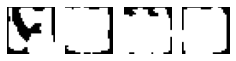

In [25]:
hist = train(ds, EPOCHS)

### Visualizing the loss

In [26]:
d_loss_list = []
g_loss_list = []
for entry in range(len(hist)):
  g_loss_list.append(hist[entry]['g_loss'].numpy())
  d_loss_list.append(hist[entry]['d_loss'].numpy())

In [ ]:
plt.title('loss')
plt.plot(d_loss_list, label='d_loss')
plt.plot(g_loss_list, label='g_loss')
plt.legend()
plt.show()

In [28]:
imgs = generator.predict(tf.random.normal((16,128,1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for i in range(4):
  for j in range(4):
    ax[i][j].imshow(np.squeeze(imgs[(i+1)*(j+1)-1]))